In [1]:
from sklearn.impute import SimpleImputer
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import random
from deap import base, creator, tools, algorithms
from sklearn.tree import DecisionTreeRegressor

from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error


Gerekli kütüphaneler implement edilir.

In [2]:
# Doğru şekilde doldurulmuş hisse senedi sembollerinin listesi
stocks = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'META', 'TSLA', 'BABA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'KO', 'PEP', 
          'MCD', 'SBUX', 'NKE', 'DIS', 'NFLX', 'CMCSA', 'VZ', 'T', 'COST', 'CVS', 'UNH', 'PFE', 'MRK', 'ABBV', 
          'BMY', 'XOM', 'CVX', 'COP', 'SLB', 'HAL', 'GE', 'BA', 'LMT', 'RTX', 'NOC', 'CAT', 'DE', 'MMM', 'HON', 
          'IBM', 'INTC', 'AMD', 'NVDA', 'QCOM', 'ORCL', 'CSCO', 'CRM', 'ADBE', 'ACN', 'MA', 'PYPL', 'SQ', 'SHOP', 
          'BAC', 'C', 'WFC', 'GS', 'BLK', 'BRK-B', 'AXP', 'TMUS', 'SPY', 'QQQ', 'DIA', 'IWM', 'GLD', 'SLV', 'USO',
            'TLT', 'HYG', 'LQD', 'EEM', 'EFA', 'FXI', 'EWJ', 'EWZ', 'RSX', 'VWO', 'VGK', 'VNQ', 'SCHH', 'XLE', 'XLF',
              'XLK', 'XLY', 'XLP', 'XLU', 'XLV', 'XLB', 'XLI','ZM','SNOW','NIO','SPCE','PLTR','DKNG']

start_date = '2023-01-01'
end_date = '2024-01-01'

# Veri çekme ve ön işleme
data = yf.download(stocks, start=start_date, end=end_date)['Adj Close'].dropna(axis=1)
returns = data.pct_change().dropna()

[*********************100%%**********************]  100 of 100 completed


100 adet hisse senedi stock değişkenine atanır ve başlangıç-bitiş zamanları verilir.
Veri çekme işlemi yapılır.

In [3]:
# Güncellenmiş hisse senedi sayısı
num_assets = len(data.columns)

# Beklenen portföy getirisini, volatiliteyi ve Sharpe oranını hesaplayan fonksiyonlar
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights) * 252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

# Sharpe oranını maksimize eden fonksiyon
def negative_sharpe(weights, mean_returns, cov_matrix, risk_free_rate=0.01):
    p_var, p_ret = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

# Kısıtlamalar ve başlangıç ağırlıkları
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
mean_returns = returns.mean()
cov_matrix = returns.cov()
initial_guess = np.array(num_assets * [1. / num_assets,])

Hisse senetlerinin değerleri güncellenir.
Optimizasyon boyunca kullanılacak olan bazı fonksiyonların hesaplamaları yapılır.
Ağırlıklar ve kısıtlar atanır.

In [4]:
# Portföy optimizasyonu
result = minimize(negative_sharpe, initial_guess, args=(mean_returns, cov_matrix), method='SLSQP', bounds=((0, 1),) * num_assets, constraints=constraints)

# Optimum portföy ağırlıklarını ve performansı hesapla
if result.success:
    optimal_weights = result.x
    print("Optimum Portföy Ağırlıkları:")
    for stock, weight in zip(data.columns, optimal_weights):
        print(f"{stock}: {weight:.2%}")

    std, ret = portfolio_performance(optimal_weights, mean_returns, cov_matrix)
    print(f"\nOptimize Edilmiş Portföyün Getirisi: {ret:.2%}")
    print(f"Optimize Edilmiş Portföyün Standart Sapması: {std:.2%}")
else:
    print("Optimizasyon başarısız.")

Optimum Portföy Ağırlıkları:
AAPL: 0.00%
ABBV: 0.00%
ACN: 0.00%
ADBE: 0.00%
AMD: 0.00%
AMZN: 0.00%
AXP: 0.00%
BA: 0.00%
BABA: 0.00%
BAC: 0.00%
BLK: 0.00%
BMY: 0.00%
BRK-B: 0.00%
C: 0.00%
CAT: 0.00%
CMCSA: 0.00%
COP: 0.00%
COST: 7.72%
CRM: 4.10%
CSCO: 0.00%
CVS: 0.00%
CVX: 0.00%
DE: 0.00%
DIA: 0.00%
DIS: 0.00%
DKNG: 2.32%
EEM: 0.00%
EFA: 0.00%
EWJ: 0.00%
EWZ: 3.90%
FXI: 0.00%
GE: 11.89%
GLD: 18.03%
GOOGL: 0.00%
GS: 0.00%
HAL: 0.00%
HON: 0.00%
HYG: 0.00%
IBM: 2.00%
INTC: 0.00%
IWM: 0.00%
JNJ: 0.00%
JPM: 0.00%
KO: 0.00%
LMT: 0.00%
LQD: 0.00%
MA: 0.00%
MCD: 0.00%
META: 6.11%
MMM: 0.00%
MRK: 0.00%
MSFT: 0.00%
NFLX: 0.00%
NIO: 0.00%
NKE: 0.00%
NOC: 0.00%
NVDA: 5.37%
ORCL: 0.00%
PEP: 0.00%
PFE: 0.00%
PG: 0.00%
PLTR: 0.00%
PYPL: 0.00%
QCOM: 0.00%
QQQ: 0.00%
RSX: 36.61%
RTX: 0.00%
SBUX: 0.00%
SCHH: 0.00%
SHOP: 0.00%
SLB: 0.00%
SLV: 0.00%
SNOW: 0.00%
SPCE: 0.00%
SPY: 0.00%
SQ: 0.00%
T: 0.00%
TLT: 0.00%
TMUS: 0.00%
TSLA: 0.00%
UNH: 1.96%
USO: 0.00%
V: 0.00%
VGK: 0.00%
VNQ: 0.00%
VWO: 0.00%
VZ: 0.

Kovaryans ve sharpe oranı gibi değerler kullanılarak portföy optimize edilir.

In [5]:
#Genetic algorithm
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import random
from deap import base, creator, tools, algorithms
from sklearn.tree import DecisionTreeRegressor

from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error

stocks = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'META', 'TSLA', 'BABA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'KO', 'PEP', 
          'MCD', 'SBUX', 'NKE', 'DIS', 'NFLX', 'CMCSA', 'VZ', 'T', 'COST', 'CVS', 'UNH', 'PFE', 'MRK', 'ABBV', 
          'BMY', 'XOM', 'CVX', 'COP', 'SLB', 'HAL', 'GE', 'BA', 'LMT', 'RTX', 'NOC', 'CAT', 'DE', 'MMM', 'HON', 
          'IBM', 'INTC', 'AMD', 'NVDA', 'QCOM', 'ORCL', 'CSCO', 'CRM', 'ADBE', 'ACN', 'MA', 'PYPL', 'SQ', 'SHOP', 
          'BAC', 'C', 'WFC', 'GS', 'BLK', 'BRK-B', 'AXP', 'TMUS', 'SPY', 'QQQ', 'DIA', 'IWM', 'GLD', 'SLV', 'USO',
            'TLT', 'HYG', 'LQD', 'EEM', 'EFA', 'FXI', 'EWJ', 'EWZ', 'RSX', 'VWO', 'VGK', 'VNQ', 'SCHH', 'XLE', 'XLF',
              'XLK', 'XLY', 'XLP', 'XLU', 'XLV', 'XLB', 'XLI','ZM','SNOW','NIO','SPCE','PLTR','DKNG']

start_date = '2023-01-01'
end_date = '2024-01-01'

# Veri çekme ve ön işleme
data = yf.download(stocks, start=start_date, end=end_date)['Adj Close'].dropna(axis=1)
returns = data.pct_change().dropna()
# DEAP kütüphanesini kullanarak FitnessMax ve Individual sınıflarını oluşturma
creator.create("FitnessMax", base.Fitness, weights=(1.0,)) # Maksimizasyon problemi için ağırlık 1.
creator.create("Individual", list, fitness=creator.FitnessMax) # Birey tanımı

toolbox = base.Toolbox()

# Bireylerin portföy ağırlıklarını rastgele olarak başlatma işlevi
def random_weights(n):
    weights = np.random.dirichlet(np.ones(n), size=1)
    return weights.tolist()[0]

toolbox.register("attr_float", random_weights, n=num_assets) # Her birey için rastgele ağırlık atama
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Uygunluk fonksiyonu: negatif Sharpe oranını hesaplar
def eval_portfolio(individual):
    return (negative_sharpe(np.array(individual), mean_returns, cov_matrix),)


toolbox.register("evaluate", eval_portfolio)
toolbox.register("mate", tools.cxBlend, alpha=0.5) # Çaprazlama işlemi için cxBlend
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2) # Mutasyon işlemi için mutGaussian
toolbox.register("select", tools.selTournament, tournsize=3) # Seçim işlemi için selTournament

# Algoritmanın parametrelerini ve nesil sayısını belirleme
# Set the parameters for the genetic algorithm
population_size = 300
number_of_generations = 100
cxpb, mutpb = 0.5, 0.2  # Crossover and mutation probabilities

# Initialize the population
population = toolbox.population(n=population_size)

# Run the genetic algorithm
hof = tools.HallOfFame(1)  # To store the best individual
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

algorithms.eaSimple(population, toolbox, cxpb, mutpb, number_of_generations, stats=stats, halloffame=hof, verbose=True)

# The best individual and its fitness
best_individual = hof[0]
print("Best Portfolio Weights:", best_individual)
print("Best Portfolio Fitness:", best_individual.fitness.values[0])


# Bu kod bloğu, portföy ağırlıklarının her birey için rastgele başlatılması, genetik algoritma işlemlerinin (seçim, çaprazlama, mutasyon) tanımlanması ve
# algoritmanın belirlenen nesil sayısı kadar iterasyonla çalıştırılması işlemlerini içerir. Kodun sonunda, en iyi bireyin portföy ağırlıkları ve uygunluk değeri yazdırılır.

# Kısıtlamalar ve başlangıç ağırlıkları doğru şekilde tanımlandı.
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
mean_returns = returns.mean()
cov_matrix = returns.cov()
initial_guess = np.array(num_assets * [1. / num_assets,])

# Sharpe oranını maksimize eden fonksiyon (uygunluk fonksiyonu olarak kullanılacak)
def sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0.01):
    p_var, p_ret = portfolio_performance(weights, mean_returns, cov_matrix)
    return (p_ret - risk_free_rate) / p_var

# Sharpe oranını maksimize etmek için negatif değerini minimize ederiz
def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0.01):
    return -sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate)

[*********************100%%**********************]  100 of 100 completed


gen	nevals	avg     	std     	min     	max      
0  	300   	-1.59002	0.206404	-2.13401	-0.898504
1  	171   	-1.11157	0.898739	-2.53413	2.59081  
2  	181   	-0.369554	1.20992 	-2.8253 	3.12438  
3  	194   	0.727483 	1.20399 	-2.7268 	3.49882  
4  	178   	1.5352   	1.04036 	-1.89584	3.66455  
5  	183   	1.99632  	0.825548	-1.08798	3.62747  
6  	185   	2.3451   	0.798402	-1.41316	3.62747  
7  	191   	2.61954  	0.813833	-1.44601	4.40329  
8  	188   	2.93549  	0.703106	0.0514158	4.45533  
9  	163   	3.24275  	0.668196	-0.239165	4.79447  
10 	179   	3.4351   	0.671411	0.279459 	4.79447  
11 	181   	3.67955  	0.571447	0.614035 	5.11158  
12 	187   	3.75649  	0.670323	-0.375753	5.11158  
13 	187   	3.93832  	0.550726	1.63702  	5.16403  
14 	174   	4.09417  	0.558498	1.3718   	5.16403  
15 	206   	4.23462  	0.537965	2.04849  	5.383    
16 	195   	4.38554  	0.502099	0.945713 	5.383    
17 	180   	4.5084   	0.414335	2.87513  	5.383    
18 	182   	4.61417  	0.45594 	2.5293   	5.62131  
19 	200   	4

Genetic algoritma implementasyonunda veri çekme ve import işlemleri yapılır.
Devamında bireylerin portföy ağırlıkları rastgele başlatılır.
Uygunluğu bulmak için negatif sharpe oranı kullanılır.
Genetic algoritmanın içinde bulunan populasyon oluşturulur ve algoritma başlatılır.
Sharpe oranı maksimize edilir.

In [6]:
#Markowitz portföy optimizasyonu
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Hisse senetlerinin listesi ve veri çekme
stocks = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'META', 'TSLA', 'BABA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'KO', 'PEP', 
          'MCD', 'SBUX', 'NKE', 'DIS', 'NFLX', 'CMCSA', 'VZ', 'T', 'COST', 'CVS', 'UNH', 'PFE', 'MRK', 'ABBV', 
          'BMY', 'XOM', 'CVX', 'COP', 'SLB', 'HAL', 'GE', 'BA', 'LMT', 'RTX', 'NOC', 'CAT', 'DE', 'MMM', 'HON', 
          'IBM', 'INTC', 'AMD', 'NVDA', 'QCOM', 'ORCL', 'CSCO', 'CRM', 'ADBE', 'ACN', 'MA', 'PYPL', 'SQ', 'SHOP', 
          'BAC', 'C', 'WFC', 'GS', 'BLK', 'BRK-B', 'AXP', 'TMUS', 'SPY', 'QQQ', 'DIA', 'IWM', 'GLD', 'SLV', 'USO',
          'TLT', 'HYG', 'LQD', 'EEM', 'EFA', 'FXI', 'EWJ', 'EWZ', 'RSX', 'VWO', 'VGK', 'VNQ', 'SCHH', 'XLE', 'XLF',
          'XLK', 'XLY', 'XLP', 'XLU', 'XLV', 'XLB', 'XLI','ZM','SNOW','NIO','SPCE','PLTR','DKNG']
start_date = '2023-01-01'
end_date = '2024-01-01'
data = yf.download(stocks, start=start_date, end=end_date)['Adj Close'].dropna(axis=1)
returns = data.pct_change().dropna()

# Fonksiyonlar ve başlangıç değerleri
mean_returns = returns.mean()
cov_matrix = returns.cov()
risk_free_rate = 0.01
num_assets = len(data.columns)
initial_guess = np.array(num_assets * [1. / num_assets,])

# Her hisse için Sharpe oranı hesaplama
sharpe_ratios = (mean_returns - risk_free_rate) / (returns.std() * np.sqrt(252))
top_5_indexes = np.argsort(sharpe_ratios)[-5:]  # En yüksek 5 Sharpe oranına sahip hisse senedinin indeksleri
top_5_stocks = data.columns[top_5_indexes]

# En iyi 5 hisse senedi için veri
selected_data = data[top_5_stocks]
selected_mean_returns = selected_data.mean() * 252
selected_cov_matrix = selected_data.cov() * 252

# Optimizasyon
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for asset in range(len(top_5_stocks)))

def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights) * 252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

def negative_sharpe_ratio(weights, mean_returns, cov_matrix):
    p_std, p_ret = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_std

result = minimize(negative_sharpe_ratio, initial_guess[:len(top_5_stocks)], args=(selected_mean_returns, selected_cov_matrix),
                  method='SLSQP', bounds=bounds, constraints=constraints)

if result.success:
    optimal_weights = result.x
    print("Optimum Portföy Ağırlıkları:")
    for stock, weight in zip(top_5_stocks, optimal_weights):
        print(f"{stock}: {weight:.2%}")

    std, ret = portfolio_performance(optimal_weights, selected_mean_returns, selected_cov_matrix)
    print(f"\nOptimize Edilmiş Portföyün Getirisi: {ret:.2%}")
    print(f"Optimize Edilmiş Portföyün Standart Sapması: {std:.2%}")
else:
    print("Optimizasyon başarısız.")


[*********************100%%**********************]  100 of 100 completed


Optimizasyon başarısız.


Aynı şekilde portföy optimizasyonu modern portföy teorisi olan Markowitz'in teorisine göre uygulanır.

[*********************100%%**********************]  100 of 100 completed


En İyi Portföyün Sharpe Oranı: 3.5588684976694958
En İyi Portföy Ağırlıkları ve Hisse Senetleri:
CRM: 23.24%
BA: 6.85%
RSX: 21.05%
META: 17.97%
NVDA: 30.89%


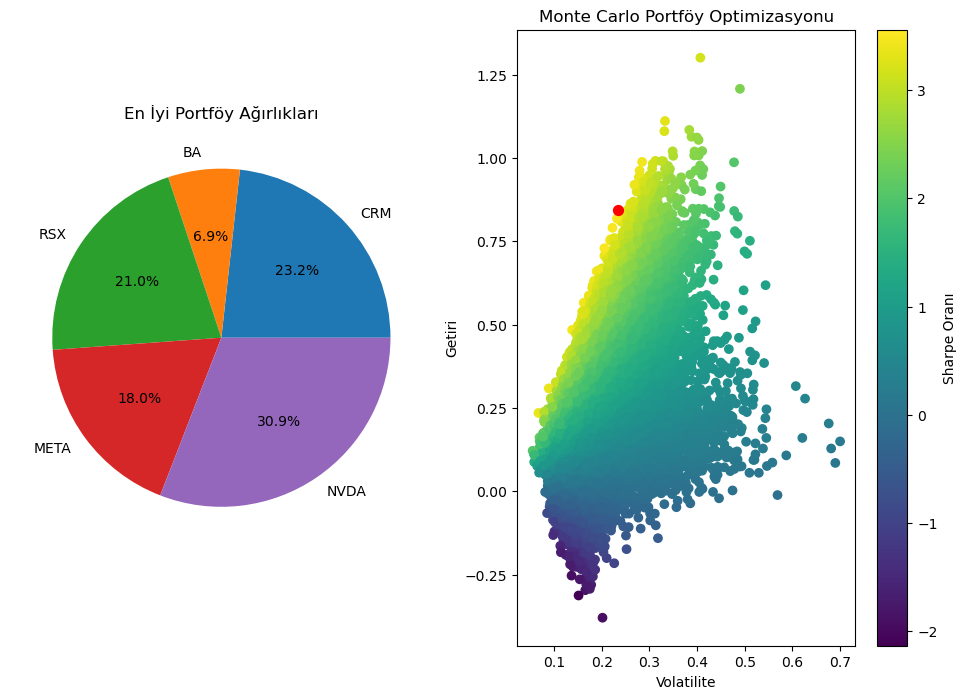

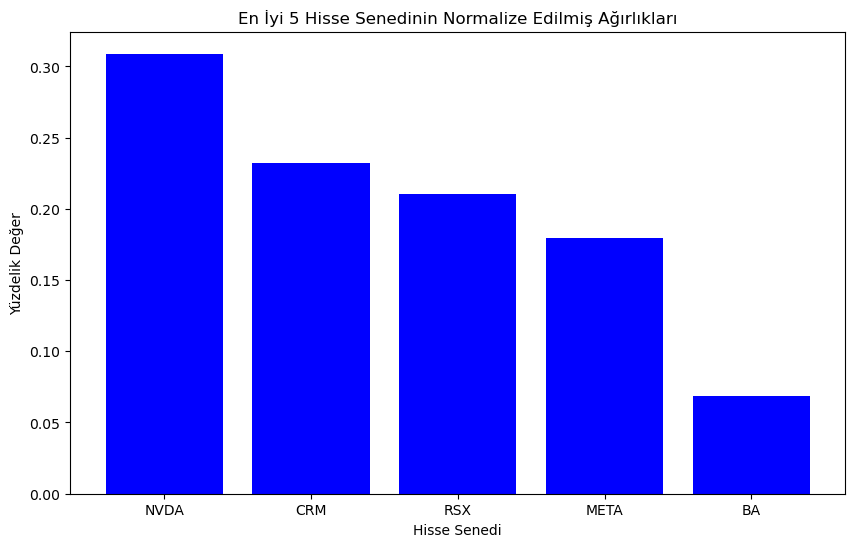

In [7]:
#Monte Carlo Simülasyonu
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# Hisse senetleri ve veri çekme
stocks = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'META', 'TSLA', 'BABA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'KO', 'PEP', 
          'MCD', 'SBUX', 'NKE', 'DIS', 'NFLX', 'CMCSA', 'VZ', 'T', 'COST', 'CVS', 'UNH', 'PFE', 'MRK', 'ABBV', 
          'BMY', 'XOM', 'CVX', 'COP', 'SLB', 'HAL', 'GE', 'BA', 'LMT', 'RTX', 'NOC', 'CAT', 'DE', 'MMM', 'HON', 
          'IBM', 'INTC', 'AMD', 'NVDA', 'QCOM', 'ORCL', 'CSCO', 'CRM', 'ADBE', 'ACN', 'MA', 'PYPL', 'SQ', 'SHOP', 
          'BAC', 'C', 'WFC', 'GS', 'BLK', 'BRK-B', 'AXP', 'TMUS', 'SPY', 'QQQ', 'DIA', 'IWM', 'GLD', 'SLV', 'USO',
          'TLT', 'HYG', 'LQD', 'EEM', 'EFA', 'FXI', 'EWJ', 'EWZ', 'RSX', 'VWO', 'VGK', 'VNQ', 'SCHH', 'XLE', 'XLF',
          'XLK', 'XLY', 'XLP', 'XLU', 'XLV', 'XLB', 'XLI','ZM','SNOW','NIO','SPCE','PLTR','DKNG']
start_date = '2023-01-01'
end_date = '2024-01-01'
data = yf.download(stocks, start=start_date, end=end_date)['Adj Close'].dropna(axis=1)
returns = data.pct_change().dropna()

num_portfolios = 50000  # Artırılmış simülasyon sayısı
num_selected = 5  # Seçilecek hisse senedi sayısı
risk_free_rate = 0.01

# Portföy getirisi ve volatilite hesaplama fonksiyonları
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights)
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return std, returns

# Monte Carlo Simülasyonu
best_sharpe = 0  # En iyi Sharpe oranını saklamak için
best_weights = np.zeros(num_selected)
best_stocks = []

mean_returns = returns.mean() * 252
cov_matrix = returns.cov() * 252
vol_arr = []
ret_arr = []
sharpe_arr = []
for i in range(num_portfolios):
    selected_indices = np.random.choice(range(len(stocks)), num_selected, replace=False)
    weights = np.random.random(num_selected)
    weights /= np.sum(weights)
    selected_returns = mean_returns.iloc[selected_indices]
    selected_cov_matrix = cov_matrix.iloc[selected_indices, selected_indices]

    std, ret = portfolio_performance(weights, selected_returns, selected_cov_matrix)
    sharpe = (ret - risk_free_rate) / std

    vol_arr.append(std)
    ret_arr.append(ret)
    sharpe_arr.append(sharpe)

    if sharpe > best_sharpe:
        best_sharpe = sharpe
        best_weights = weights
        best_stocks = data.columns[selected_indices]

max_sharpe_idx = np.argmax(sharpe_arr)  # En iyi Sharpe oranının indeksini belirle


print("En İyi Portföyün Sharpe Oranı:", best_sharpe)
print("En İyi Portföy Ağırlıkları ve Hisse Senetleri:")
for stock, weight in zip(best_stocks, best_weights):
    print(f"{stock}: {weight:.2%}")

# Görselleştirme
plt.figure(figsize=(12, 8))

# Portföy ağırlıklarının pasta grafiği
plt.subplot(1, 2, 1)
plt.pie(best_weights, labels=best_stocks, autopct='%1.1f%%')
plt.title("En İyi Portföy Ağırlıkları")

# Sharpe oranının scatter grafiği
plt.subplot(1, 2, 2)
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Oranı')
plt.xlabel('Volatilite')
plt.ylabel('Getiri')
plt.scatter(vol_arr[max_sharpe_idx], ret_arr[max_sharpe_idx], c='red', s=50)  # En iyi portföy
plt.title("Monte Carlo Portföy Optimizasyonu")

plt.show()

# En iyi 5 hisse senedi ve ağırlıklarını bulma
sorted_idx = np.argsort(best_weights)[::-1][:5]  # En yüksek ağırlıklara sahip ilk 5 indexi alır
top_5_stocks = best_stocks[sorted_idx]  # İndexlere göre hisse senetlerini alır
top_5_weights = best_weights[sorted_idx]  # İndexlere göre ağırlıkları alır

# Ağırlıkları normalize etme
normalized_weights = top_5_weights / np.sum(top_5_weights)

# Opsiyonel: Normalize edilmiş yüzdelik değerleri görselleştirme
plt.figure(figsize=(10, 6))
plt.bar(top_5_stocks, normalized_weights, color='blue')
plt.xlabel('Hisse Senedi')
plt.ylabel('Yüzdelik Değer')
plt.title('En İyi 5 Hisse Senedinin Normalize Edilmiş Ağırlıkları')
plt.show()


Portföy getirisi ve volatilite hesaplama fonksiyonları yazılır.
Devamında simülasyonda en iyi sharpe oranı bulunmaya çalışılır.

Görselleştirme yapılır.
Burada pasta grafiği ve sütun grafiği kullandık.
Monte Carlo Portföy optimizasyonunda volalite ve sharpe oranını inceledik.

Hisse Senedi Beklenen Getirileri (CAPM):
AAPL: 15.41%
ABBV: 9.08%
ACN: 16.55%
ADBE: 20.48%
AMD: 10.70%
AMZN: 20.67%
AXP: 19.63%
BA: 24.36%
BABA: 11.66%
BAC: 21.57%
BLK: 24.50%
BMY: 2.02%
BRK-B: 7.03%
C: 2.82%
CAT: 17.25%
CMCSA: 23.78%
COP: 18.79%
COST: 19.55%
CRM: 3.10%
CSCO: 23.06%
CVS: 21.31%
CVX: 21.56%
DE: 7.10%
DIA: 2.35%
DIS: 1.14%
DKNG: 2.34%
EEM: 20.26%
EFA: 11.15%
EWJ: 9.23%
EWZ: 6.12%
FXI: 20.81%
GE: 4.06%
GLD: 7.81%
GOOGL: 18.61%
GS: 2.84%
HAL: 21.49%
HON: 14.27%
HYG: 5.28%
IBM: 9.60%
INTC: 10.19%
IWM: 18.14%
JNJ: 12.09%
JPM: 1.19%
KO: 17.66%
LMT: 12.39%
LQD: 19.06%
MA: 16.43%
MCD: 22.32%
META: 5.09%
MMM: 1.51%
MRK: 1.81%
MSFT: 11.31%
NFLX: 10.21%
NIO: 9.59%
NKE: 19.37%
NOC: 13.73%
NVDA: 4.74%
ORCL: 8.20%
PEP: 19.30%
PFE: 22.83%
PG: 18.21%
PLTR: 8.73%
PYPL: 17.87%
QCOM: 19.50%
QQQ: 14.33%
RSX: 17.19%
RTX: 15.54%
SBUX: 22.38%
SCHH: 7.10%
SHOP: 13.84%
SLB: 10.05%
SLV: 18.20%
SNOW: 19.14%
SPCE: 19.65%
SPY: 22.02%
SQ: 12.99%
T: 17.83%
TLT: 6.81%
TMUS: 16.55%
TSLA: 15.01%
UNH: 2.

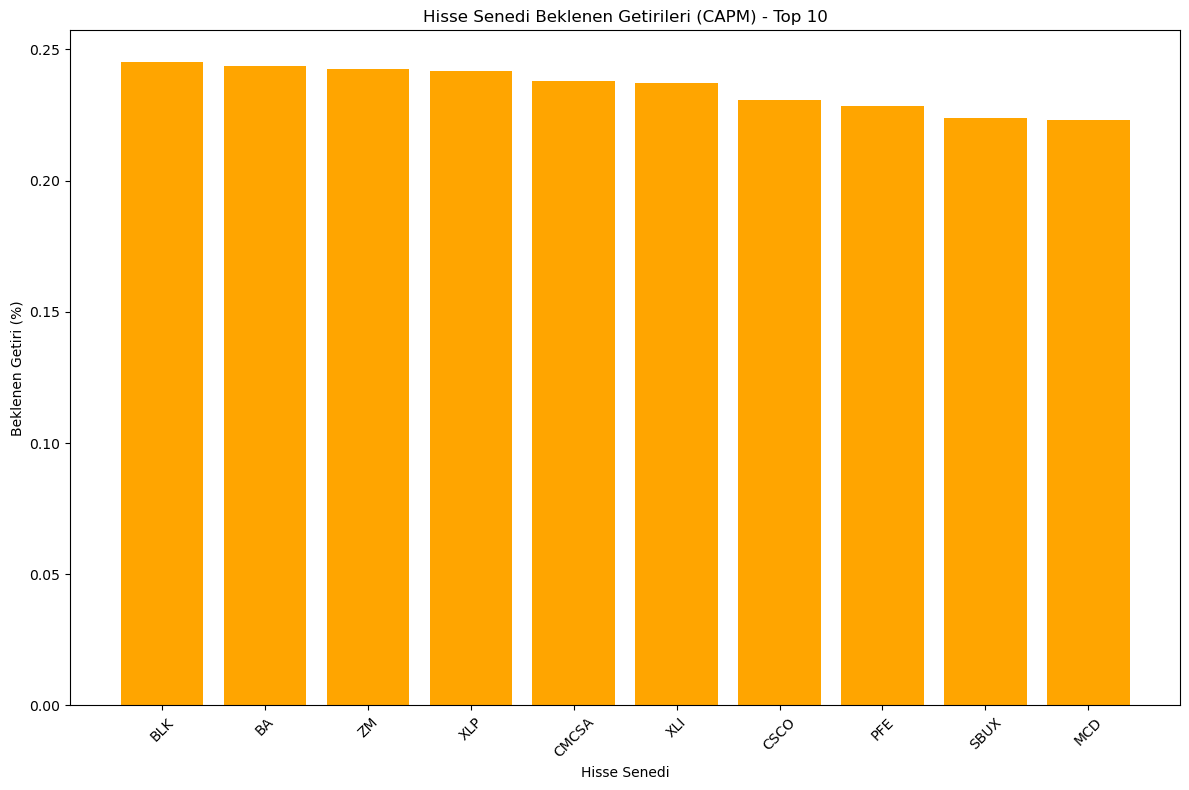

En İyi 5 Hisse Senedi ve Portföy Ağırlıkları:
BLK: 20.24%
BA: 20.12%
ZM: 20.02%
XLP: 19.98%
CMCSA: 19.64%


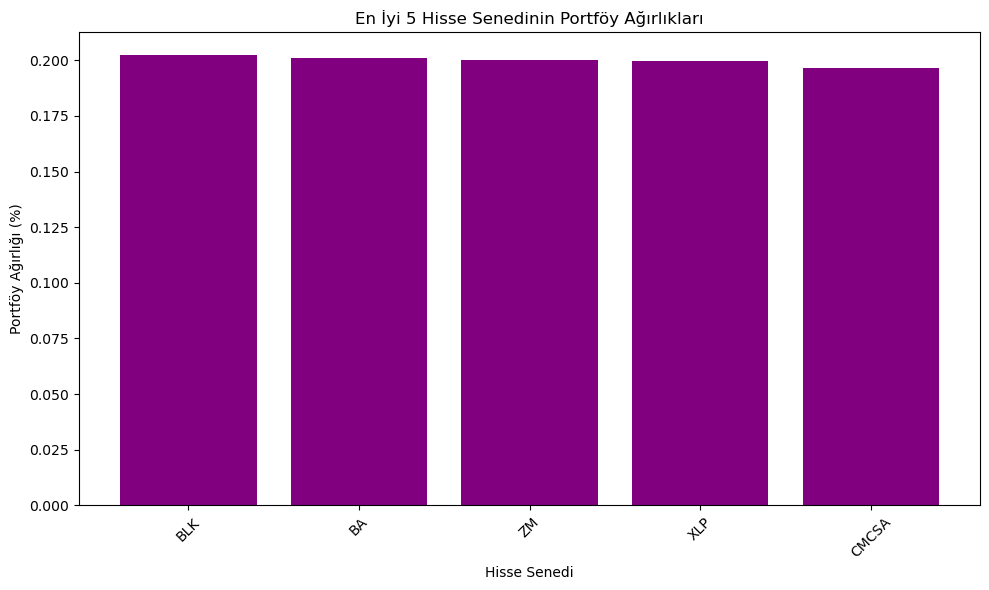

In [8]:
#CAPM yaklaşımı ile hisse senedi getirileri ve piyasa getirileri arasındaki ilişkiyi incelemek için regresyon analizi yapılır.
# Risk serbest getiri oranı ve piyasa portföyünün getirisi
risk_free_rate = 0.01  # Örnek değer
market_return = returns['SPY'].mean() * 252  # SPY, S&P 500 endeksini temsil eder

# Beta değerlerini hesaplama (burada basitlik adına sabit değerler kullanacağız, gerçekte ise hisse senedi verilerinden hesaplanmalıdır)
betas = {stock: np.random.rand() for stock in data.columns}  # Her hisse için rastgele beta değeri

# CAPM formülüyle beklenen getirileri hesaplama
expected_returns = {}
for stock, beta in betas.items():
    expected_return = risk_free_rate + beta * (market_return - risk_free_rate)
    expected_returns[stock] = expected_return

# Beklenen getirileri yazdırma
print("Hisse Senedi Beklenen Getirileri (CAPM):")
for stock, exp_return in expected_returns.items():
    print(f"{stock}: {exp_return:.2%}")


# Beklenen getirileri büyükten küçüğe sırala ve en yüksek 10'unu seç
top_expected_returns = dict(sorted(expected_returns.items(), key=lambda item: item[1], reverse=True)[:10])

# Beklenen getirileri görselleştirme
plt.figure(figsize=(12, 8))
plt.bar(top_expected_returns.keys(), top_expected_returns.values(), color='orange')
plt.xlabel('Hisse Senedi')
plt.ylabel('Beklenen Getiri (%)')
plt.title('Hisse Senedi Beklenen Getirileri (CAPM) - Top 10')
plt.xticks(rotation=45)  # Etiketleri eğik yapar
plt.tight_layout()  # Düzeni iyileştirir
plt.show()

# Beklenen getirilere göre en iyi 5 hisse senedini seç
top_5_expected_returns = dict(sorted(expected_returns.items(), key=lambda item: item[1], reverse=True)[:5])

# Seçilen hisse senetlerinin beklenen getirilerine göre ağırlıkları hesaplama
total_return = sum(top_5_expected_returns.values())
weights = {stock: exp_return / total_return for stock, exp_return in top_5_expected_returns.items()}

# Seçilen hisse senetleri ve ağırlıklarını yazdır
print("En İyi 5 Hisse Senedi ve Portföy Ağırlıkları:")
for stock, weight in weights.items():
    print(f"{stock}: {weight:.2%}")

# Portföy ağırlıklarını görselleştirme
plt.figure(figsize=(10, 6))
plt.bar(weights.keys(), weights.values(), color='purple')
plt.xlabel('Hisse Senedi')
plt.ylabel('Portföy Ağırlığı (%)')
plt.title('En İyi 5 Hisse Senedinin Portföy Ağırlıkları')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


CAPM yaklaşımı ile hisse senedi getirileri ve piyasa getirileri arasındaki ilişkiyi incelemek için regresyon analizi yapılır.
Risk serbest getiri oranı ve piyasa portföyünün getirisi hesaplanır.
Beta değerlerini hesaplama (burada basitlik adına sabit değerler kullanacağız, gerçekte ise hisse senedi verilerinden hesaplanmalıdır)
Devamında beklenen getiri hesaplamaları ile en iyi 5 hisse senedinden oluşan portföy oluşturulur.

[*********************100%%**********************]  100 of 100 completed


Risk Parity Portföy Ağırlıkları:
AAPL: 0.77%
ABBV: 0.76%
ACN: 0.84%
ADBE: 1.23%
AMD: 1.81%
AMZN: 1.27%
AXP: 1.00%
BA: 1.04%
BABA: 1.58%
BAC: 1.04%
BLK: 0.85%
BMY: 0.75%
BRK-B: 0.53%
C: 0.98%
CAT: 1.10%
CMCSA: 0.92%
COP: 1.10%
COST: 0.74%
CRM: 1.14%
CSCO: 0.78%
CVS: 0.94%
CVX: 0.89%
DE: 1.05%
DIA: 0.44%
DIS: 1.02%
DKNG: 2.06%
EEM: 0.60%
EFA: 0.52%
EWJ: 0.58%
EWZ: 0.96%
FXI: 1.07%
GE: 0.94%
GLD: 0.52%
GOOGL: 1.17%
GS: 0.93%
HAL: 1.39%
HON: 0.71%
HYG: 0.29%
IBM: 0.61%
INTC: 1.48%
IWM: 0.77%
JNJ: 0.64%
JPM: 0.80%
KO: 0.52%
LMT: 0.70%
LQD: 0.37%
MA: 0.66%
MCD: 0.54%
META: 1.53%
MMM: 1.05%
MRK: 0.73%
MSFT: 0.97%
NFLX: 1.45%
NIO: 2.53%
NKE: 1.04%
NOC: 0.88%
NVDA: 1.87%
ORCL: 1.16%
PEP: 0.58%
PFE: 0.89%
PG: 0.57%
PLTR: 2.67%
PYPL: 1.40%
QCOM: 1.21%
QQQ: 0.69%
RSX: 0.34%
RTX: 0.92%
SBUX: 0.87%
SCHH: 0.77%
SHOP: 2.28%
SLB: 1.29%
SLV: 0.96%
SNOW: 2.08%
SPCE: 3.78%
SPY: 0.50%
SQ: 1.93%
T: 1.04%
TLT: 0.71%
TMUS: 0.73%
TSLA: 2.03%
UNH: 0.81%
USO: 1.20%
V: 0.60%
VGK: 0.57%
VNQ: 0.78%
VWO: 0.55%
VZ: 0

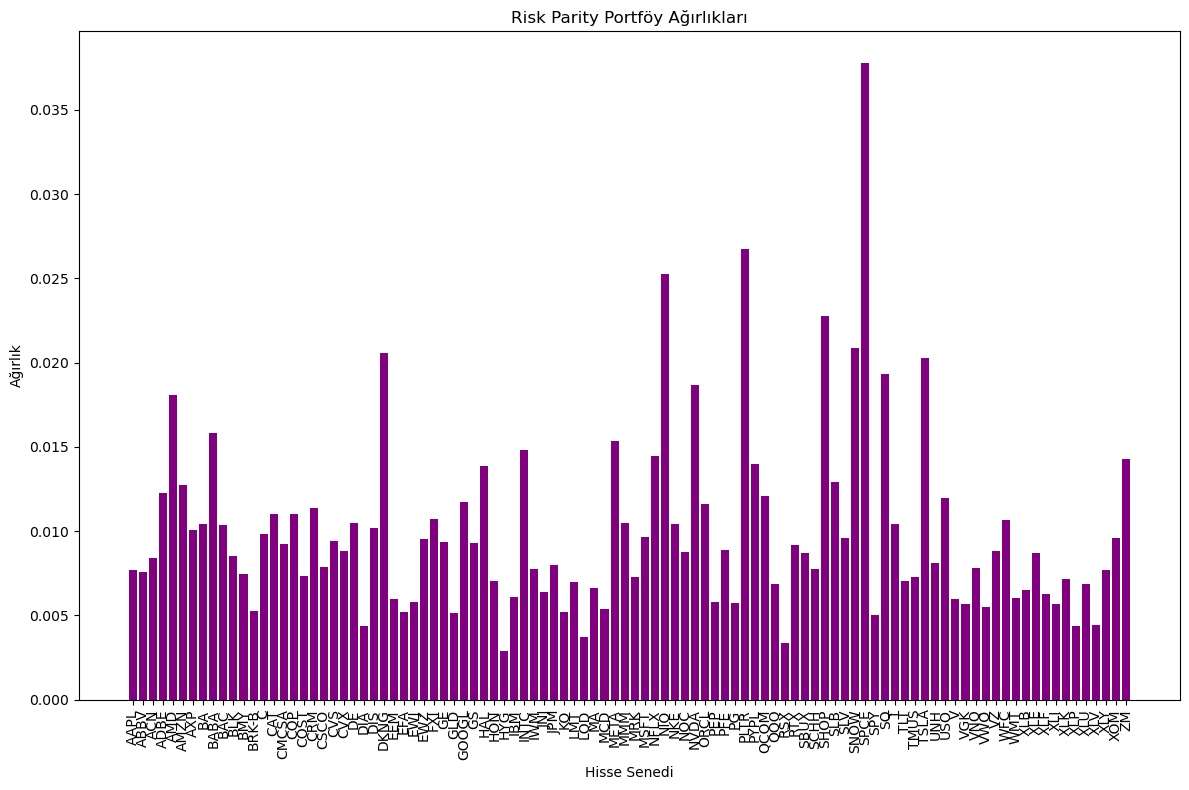

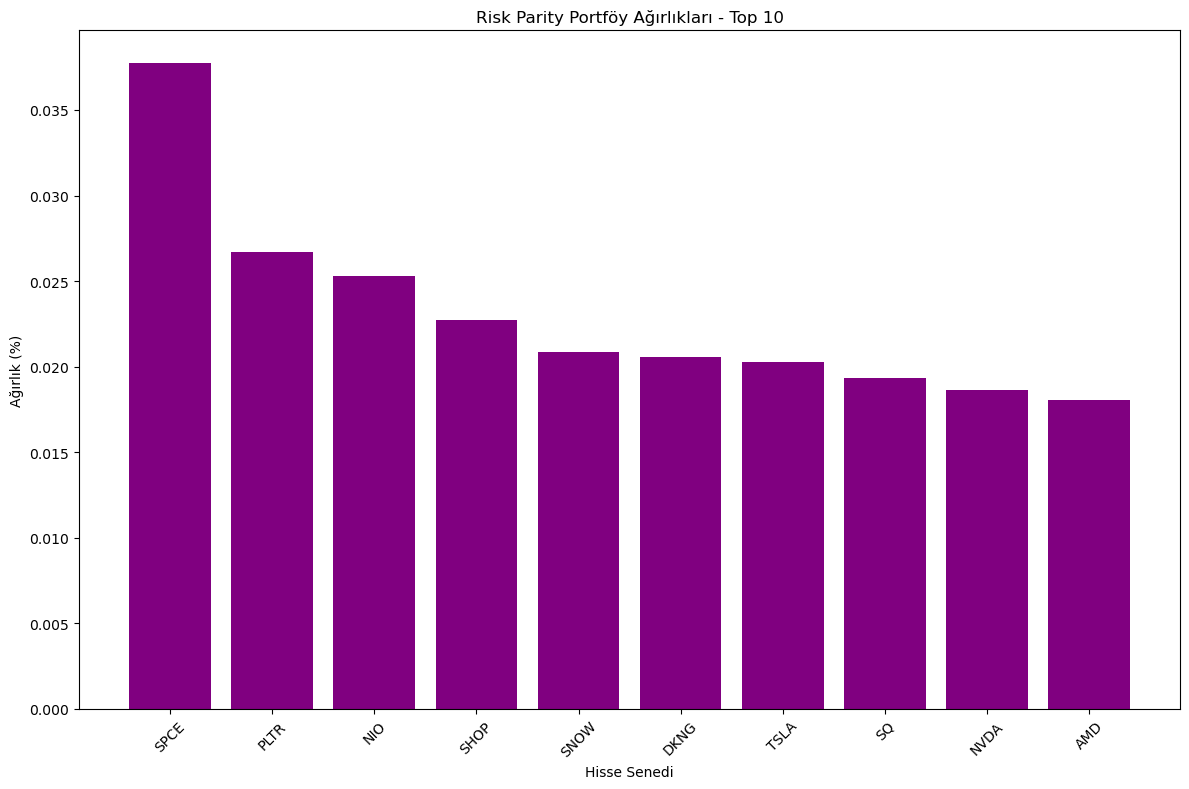

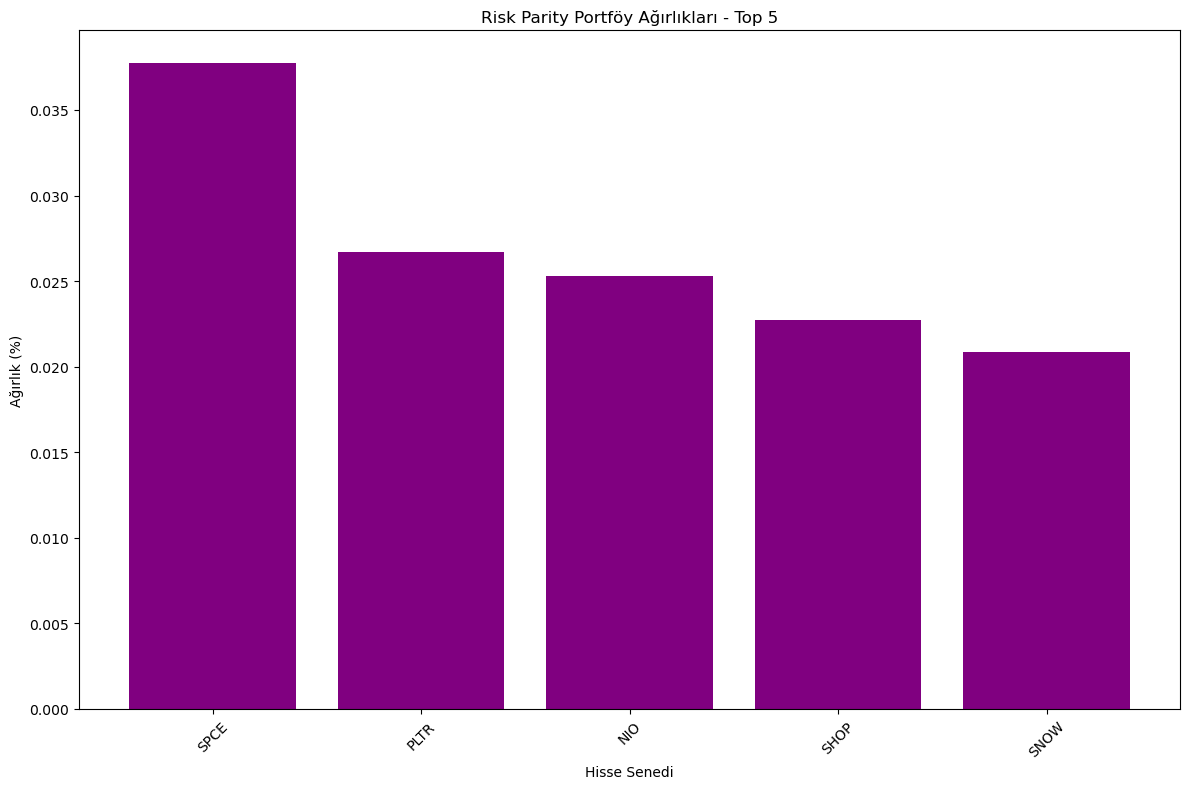

In [9]:
from sklearn.impute import SimpleImputer
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import random
from deap import base, creator, tools, algorithms
from sklearn.tree import DecisionTreeRegressor

from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Doğru şekilde doldurulmuş hisse senedi sembollerinin listesi
stocks = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'META', 'TSLA', 'BABA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'KO', 'PEP', 
          'MCD', 'SBUX', 'NKE', 'DIS', 'NFLX', 'CMCSA', 'VZ', 'T', 'COST', 'CVS', 'UNH', 'PFE', 'MRK', 'ABBV', 
          'BMY', 'XOM', 'CVX', 'COP', 'SLB', 'HAL', 'GE', 'BA', 'LMT', 'RTX', 'NOC', 'CAT', 'DE', 'MMM', 'HON', 
          'IBM', 'INTC', 'AMD', 'NVDA', 'QCOM', 'ORCL', 'CSCO', 'CRM', 'ADBE', 'ACN', 'MA', 'PYPL', 'SQ', 'SHOP', 
          'BAC', 'C', 'WFC', 'GS', 'BLK', 'BRK-B', 'AXP', 'TMUS', 'SPY', 'QQQ', 'DIA', 'IWM', 'GLD', 'SLV', 'USO',
            'TLT', 'HYG', 'LQD', 'EEM', 'EFA', 'FXI', 'EWJ', 'EWZ', 'RSX', 'VWO', 'VGK', 'VNQ', 'SCHH', 'XLE', 'XLF',
              'XLK', 'XLY', 'XLP', 'XLU', 'XLV', 'XLB', 'XLI','ZM','SNOW','NIO','SPCE','PLTR','DKNG']

start_date = '2023-01-01'
end_date = '2024-01-01'

# Veri çekme ve ön işleme
data = yf.download(stocks, start=start_date, end=end_date)['Adj Close'].dropna(axis=1)
returns = data.pct_change().dropna()

# Güncellenmiş hisse senedi sayısı
num_assets = len(data.columns)

# Beklenen portföy getirisini, volatiliteyi ve Sharpe oranını hesaplayan fonksiyonlar
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights) * 252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

# Sharpe oranını maksimize eden fonksiyon
def negative_sharpe(weights, mean_returns, cov_matrix, risk_free_rate=0.01):
    p_var, p_ret = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

# Kısıtlamalar ve başlangıç ağırlıkları
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
mean_returns = returns.mean()
cov_matrix = returns.cov()
initial_guess = np.array(num_assets * [1. / num_assets,])


#Risk Parity portföyü oluşturulur. Her bir varlığın yıllık volatilitesini hesaplar. Varlıkların korelasyon matrisini hesaplar. Her bir varlık için marjinal risk katkısını hesaplar. Risk Parity için ağırlıkları hesaplar. Ağırlıkları görselleştirir.
# Her bir varlığın yıllık volatilitesini hesapla
volatilities = returns.std() * np.sqrt(252)

# Varlıkların korelasyon matrisini hesapla
correlation_matrix = returns.corr()

# Her bir varlık için marjinal risk katkısını hesapla
marginal_risk_contribution = volatilities / volatilities.sum()

# Risk Parity için ağırlıkları hesapla
risk_parity_weights = marginal_risk_contribution / marginal_risk_contribution.sum()

# Ağırlıkları yazdır
print("Risk Parity Portföy Ağırlıkları:")
for stock, weight in zip(data.columns, risk_parity_weights):
    print(f"{stock}: {weight:.2%}")

# Opsiyonel: Ağırlıkları görselleştirme
plt.figure(figsize=(12, 8))
plt.bar(data.columns, risk_parity_weights, color='purple')
plt.xlabel('Hisse Senedi')
plt.ylabel('Ağırlık')
plt.title('Risk Parity Portföy Ağırlıkları')
plt.xticks(rotation=90)  # Hisse senedi isimlerini dikey olarak döndür
plt.tight_layout()  # Grafik düzenini iyileştir
plt.show()

# Risk Parity ağırlıklarını büyükten küçüğe sırala ve en yüksek 10'unu seç
top_risk_parity_weights = dict(sorted(zip(data.columns, risk_parity_weights), key=lambda item: item[1], reverse=True)[:10])

# Risk Parity ağırlıklarını görselleştirme
plt.figure(figsize=(12, 8))
plt.bar(top_risk_parity_weights.keys(), top_risk_parity_weights.values(), color='purple')
plt.xlabel('Hisse Senedi')
plt.ylabel('Ağırlık (%)')
plt.title('Risk Parity Portföy Ağırlıkları - Top 10')
plt.xticks(rotation=45)  # Etiketleri eğik yapar
plt.tight_layout()  # Düzeni iyileştirir
plt.show()

# Risk Parity ağırlıklarını büyükten küçüğe sırala ve en yüksek 5'ini seç
top_5_risk_parity_weights = dict(sorted(zip(data.columns, risk_parity_weights), key=lambda item: item[1], reverse=True)[:5])

# Risk Parity ağırlıklarını görselleştirme
plt.figure(figsize=(12, 8))
plt.bar(top_5_risk_parity_weights.keys(), top_5_risk_parity_weights.values(), color='purple')
plt.xlabel('Hisse Senedi')
plt.ylabel('Ağırlık (%)')
plt.title('Risk Parity Portföy Ağırlıkları - Top 5')
plt.xticks(rotation=45)  # Etiketleri eğik yapar
plt.tight_layout()  # Düzeni iyileştirir
plt.show()


Risk Parity algoritmasında ise her bir varlığın yıllık volatilitesini hesaplar. Varlıkların korelasyon matrisini hesaplar. Her bir varlık için marjinal risk katkısını hesaplar. Risk Parity için ağırlıkları hesaplar. Ağırlıkları görselleştirir.
Her bir varlığın yıllık volatilitesini hesaplanır.
Varlıkların korelasyon matrisi hesaplanır.
Aynı zamanda marjinal risk katkısı da hesaplanır ve karşılaştırılır.
Bu algoritmada yine sharpe oranı maksimize edilmeye çalışılır.

[*********************100%%**********************]  100 of 100 completed


Karar Ağaçları ile Seçilen En İyi 10 Hisse Senedi ve Tahmin Edilen Ortalama Getirileri:
Ticker
NVDA    0.006316
NFLX    0.005232
GE      0.005079
SQ      0.005031
AMD     0.004622
dtype: float64


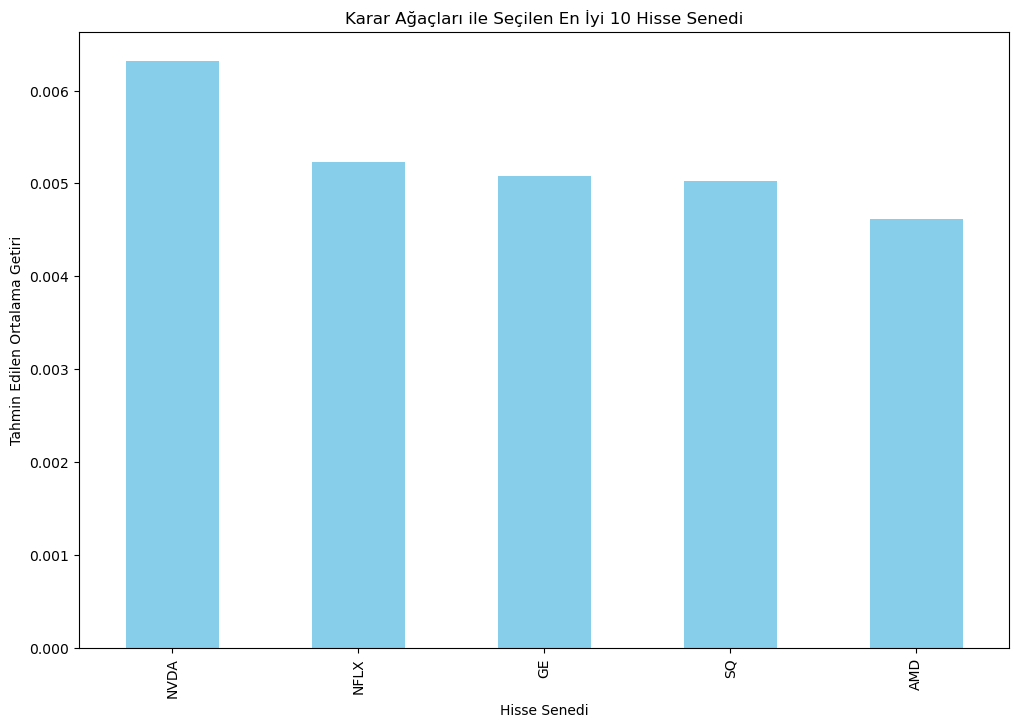

In [10]:
#Karar ağaçları ile hisse senedi getirileri tahmin edilir ve en iyi 10 hisse senedi seçilir.
# Veriyi yükleme (son 6 ay)
end_date = pd.to_datetime('today')
start_date = end_date - pd.DateOffset(months=6)
data = yf.download(stocks, start=start_date, end=end_date)['Adj Close']

# Günlük getirileri hesaplama
returns = data.pct_change(fill_method=None)

# Özellikler ve hedefler
X = returns.shift(1).rolling(window=5).mean()  # Geçmiş 5 günlük ortalama getiriler
y = returns.shift(-1)  # Gelecekteki 1 günlük getiriler

# NaN değerlerin temizlenmesi
X = X.dropna()
y = y.dropna()

# İndekslerin eşleşmesini sağlama
common_index = X.index.intersection(y.index)
X = X.loc[common_index]
y = y.loc[common_index]

# Karar ağacı modelini eğitme
model = DecisionTreeRegressor(max_depth=5)
model.fit(X, y)

# Gelecekteki getirileri tahmin etme
predicted_returns = model.predict(X)

# Tahmin edilen getirileri DataFrame'e dönüştürme
predicted_returns_df = pd.DataFrame(predicted_returns, columns=y.columns, index=X.index)

# Ortalama tahmin edilen getirilere göre en iyi 5 hisse senedini seçme
top_stocks = predicted_returns_df.mean().nlargest(5)

# Seçilen hisse senetlerini ve tahmin edilen ortalama getirilerini yazdırma
print("Karar Ağaçları ile Seçilen En İyi 10 Hisse Senedi ve Tahmin Edilen Ortalama Getirileri:")
print(top_stocks)

# Opsiyonel: Seçilen hisse senetlerini ve tahmin edilen getirilerini görselleştirme
plt.figure(figsize=(12, 8))
top_stocks.plot(kind='bar', color='skyblue')
plt.xlabel('Hisse Senedi')
plt.ylabel('Tahmin Edilen Ortalama Getiri')
plt.title('Karar Ağaçları ile Seçilen En İyi 10 Hisse Senedi')
plt.show()

Veriler eklenir ve makine öğrenmesi metodu olan Karar Ağacı yöntemi uygulanır.
Bu yöntem uygulanırken karşımıza NaN değerler çıkar ve bu NaN değerlerin temizlenmesi gerekir.(Daha iyi bir sonuç almak için)
Son olarak eğitilen modelden en iyi 5 hisse senedi seçilerek görselleştime yapılır.

[*********************100%%**********************]  100 of 100 completed


Optimum Portföy Ağırlıkları:
NVDA: 12.11%
SQ: 5.42%
GE: 56.05%
META: 6.57%
NFLX: 19.85%


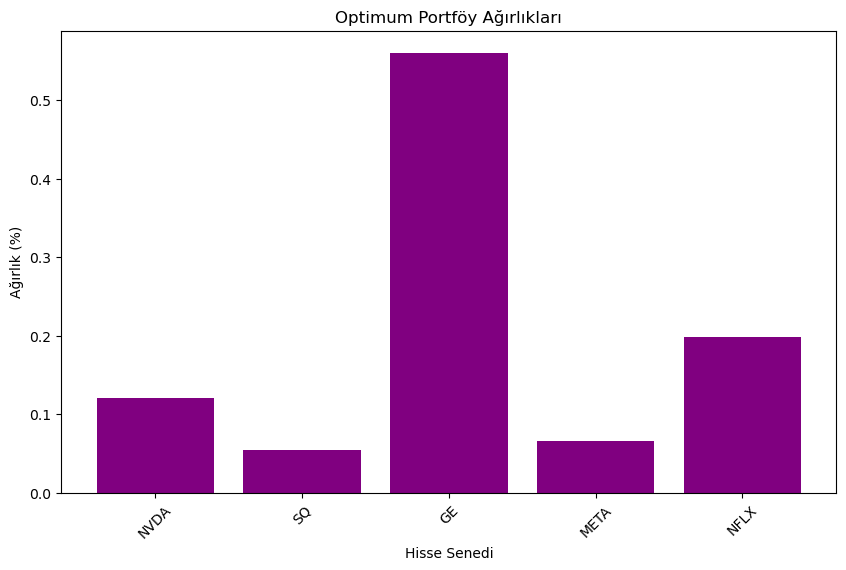

In [11]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import yfinance as yf

stocks = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'META', 'TSLA', 'BABA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'KO', 'PEP', 
          'MCD', 'SBUX', 'NKE', 'DIS', 'NFLX', 'CMCSA', 'VZ', 'T', 'COST', 'CVS', 'UNH', 'PFE', 'MRK', 'ABBV', 
          'BMY', 'XOM', 'CVX', 'COP', 'SLB', 'HAL', 'GE', 'BA', 'LMT', 'RTX', 'NOC', 'CAT', 'DE', 'MMM', 'HON', 
          'IBM', 'INTC', 'AMD', 'NVDA', 'QCOM', 'ORCL', 'CSCO', 'CRM', 'ADBE', 'ACN', 'MA', 'PYPL', 'SQ', 'SHOP', 
          'BAC', 'C', 'WFC', 'GS', 'BLK', 'BRK-B', 'AXP', 'TMUS', 'SPY', 'QQQ', 'DIA', 'IWM', 'GLD', 'SLV', 'USO',
            'TLT', 'HYG', 'LQD', 'EEM', 'EFA', 'FXI', 'EWJ', 'EWZ', 'RSX', 'VWO', 'VGK', 'VNQ', 'SCHH', 'XLE', 'XLF',
              'XLK', 'XLY', 'XLP', 'XLU', 'XLV', 'XLB', 'XLI','ZM','SNOW','NIO','SPCE','PLTR','DKNG']

start_date = '2023-01-01'
end_date = '2024-01-01'
data = yf.download(stocks, start=start_date, end=end_date)['Adj Close']

# Hisse senetlerinin yıllık getirilerini hesapla ve en iyi 5'ini seç
mean_returns = returns.mean() * 252
top_5_stocks = mean_returns.nlargest(5).index

# Seçilen hisse senetlerinin getirilerini ve kovaryans matrisini almak
selected_returns = returns[top_5_stocks]
selected_cov_matrix = selected_returns.cov()

# Seçilen hisse senetlerinin yıllık getirilerini sınırla
mean_returns = mean_returns[top_5_stocks]

# Kısıtlamalar ve başlangıç ağırlıkları
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
initial_guess = np.array([1. / len(top_5_stocks)] * len(top_5_stocks))

# Sharpe oranını maksimize eden fonksiyon
def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0.01):
    p_ret = np.sum(mean_returns * weights) * 252
    p_var = np.dot(weights.T, np.dot(cov_matrix * 252, weights))
    return -(p_ret - risk_free_rate) / np.sqrt(p_var)

# Portföy optimizasyonu
result = minimize(negative_sharpe_ratio, initial_guess, args=(mean_returns, selected_cov_matrix), method='SLSQP', bounds=((0, 1),) * len(top_5_stocks), constraints=constraints)

# Optimum portföy ağırlıklarını ve performansı hesapla
if result.success:
    optimal_weights = result.x
    print("Optimum Portföy Ağırlıkları:")
    for stock, weight in zip(top_5_stocks, optimal_weights):
        print(f"{stock}: {weight:.2%}")

    # Görselleştirme
    plt.figure(figsize=(10, 6))
    plt.bar(top_5_stocks, optimal_weights, color='purple')
    plt.xlabel('Hisse Senedi')
    plt.ylabel('Ağırlık (%)')
    plt.title('Optimum Portföy Ağırlıkları')
    plt.xticks(rotation=45)
    plt.show()

else:
    print("Optimizasyon başarısız.")


[*********************100%%**********************]  100 of 100 completed


Top 5 Predicted Performing Stocks: ['META', 'SHOP', 'NVDA', 'PLTR', 'CRM']
Optimal Weights: [3.54514528e-01 4.32461142e-17 2.94056299e-01 1.17631854e-02
 3.39665987e-01]


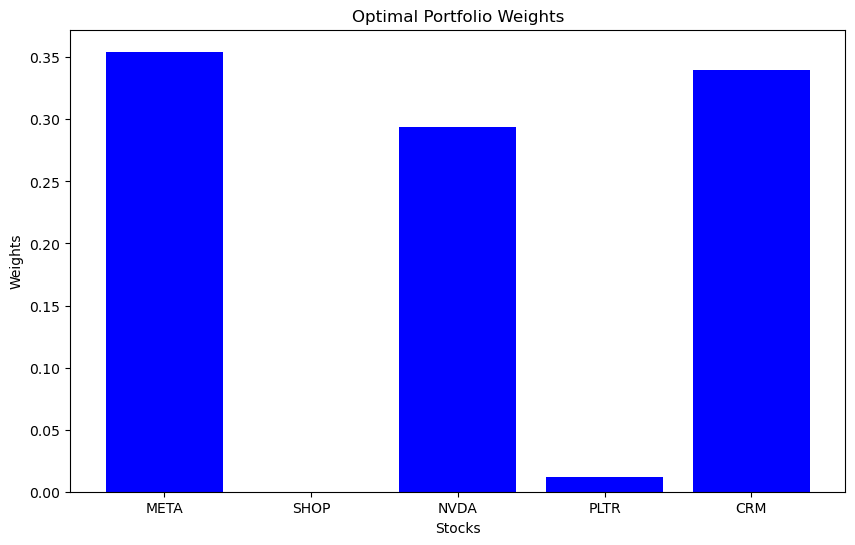

In [12]:
#SVM ile hisse senedi getirileri tahmin edilir ve gerçek getirilerle karşılaştırılır.
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import random
from deap import base, creator, tools, algorithms
from sklearn.tree import DecisionTreeRegressor

from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error

stocks = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'META', 'TSLA', 'BABA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'KO', 'PEP', 
          'MCD', 'SBUX', 'NKE', 'DIS', 'NFLX', 'CMCSA', 'VZ', 'T', 'COST', 'CVS', 'UNH', 'PFE', 'MRK', 'ABBV', 
          'BMY', 'XOM', 'CVX', 'COP', 'SLB', 'HAL', 'GE', 'BA', 'LMT', 'RTX', 'NOC', 'CAT', 'DE', 'MMM', 'HON', 
          'IBM', 'INTC', 'AMD', 'NVDA', 'QCOM', 'ORCL', 'CSCO', 'CRM', 'ADBE', 'ACN', 'MA', 'PYPL', 'SQ', 'SHOP', 
          'BAC', 'C', 'WFC', 'GS', 'BLK', 'BRK-B', 'AXP', 'TMUS', 'SPY', 'QQQ', 'DIA', 'IWM', 'GLD', 'SLV', 'USO',
            'TLT', 'HYG', 'LQD', 'EEM', 'EFA', 'FXI', 'EWJ', 'EWZ', 'RSX', 'VWO', 'VGK', 'VNQ', 'SCHH', 'XLE', 'XLF',
              'XLK', 'XLY', 'XLP', 'XLU', 'XLV', 'XLB', 'XLI','ZM','SNOW','NIO','SPCE','PLTR','DKNG']

start_date = '2023-01-01'
end_date = '2024-01-01'

# Veri çekme ve ön işleme
data = yf.download(stocks, start=start_date, end=end_date)['Adj Close'].dropna(axis=1)
returns = data.pct_change().dropna()
# Tahminler için bir sözlük oluştur
predicted_returns = {}

# Her hisse senedi için bir SVM modeli eğit
for stock in stocks:
    # Hedef hisse senedinin getirilerini ve diğer hisse senetlerini özellik olarak ayır
    y = returns[stock]
    X = returns.drop(columns=stock)
    
    # Veriyi eğitim ve test setlerine ayırma
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Veri ölçeklendirme
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # SVM modelini tanımlama ve eğitme
    svr = SVR(kernel='rbf', C=1.0, gamma='auto')
    svr.fit(X_train_scaled, y_train)
    
    # Her hisse senedi için ortalama tahmini getiri hesaplama
    predicted_returns[stock] = np.mean(svr.predict(X_test_scaled))

# Tahmin edilen getirilere göre en iyi 5 hisse senedini seç
top_5_stocks = sorted(predicted_returns, key=predicted_returns.get, reverse=True)[:5]
print("Top 5 Predicted Performing Stocks:", top_5_stocks)


# Seçilen hisse senetlerinin getirileri ve kovaryans matrisini almak
selected_returns = returns[top_5_stocks]
selected_cov_matrix = selected_returns.cov()

# Portföy optimizasyonu için negatif Sharpe oranı fonksiyonu
def negative_sharpe_ratio(weights, returns, cov_matrix, risk_free_rate=0.01):
    p_returns = np.dot(weights, returns.mean()) * 252
    p_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))
    sharpe_ratio = (p_returns - risk_free_rate) / p_volatility
    return -sharpe_ratio

# Başlangıç ağırlıkları ve kısıtlamalar
initial_weights = np.ones(len(top_5_stocks)) / len(top_5_stocks)
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Portföy optimizasyonu
result = minimize(negative_sharpe_ratio, initial_weights, args=(selected_returns, selected_cov_matrix),
                  method='SLSQP', bounds=((0, 1),) * len(top_5_stocks), constraints=constraints)

if result.success:
    optimal_weights = result.x
    print("Optimal Weights:", optimal_weights)
    
    # Optimum portföy ağırlıklarını görselleştirme
    plt.figure(figsize=(10, 6))
    plt.bar(top_5_stocks, optimal_weights, color='blue')
    plt.xlabel('Stocks')
    plt.ylabel('Weights')
    plt.title('Optimal Portfolio Weights')
    plt.show()
else:
    print("Optimization failed:", result.message)


Burada makine öğrenmesi yöntemi olan SVM(Support Vector Machiene) yöntemi kullanılır.
Bu yöntemde her hisse senedi için ayrı bir model eğitimi yapılır.
Kısıtlamalar, sharpe oranı ve volalite hesaplar.
Tahminler yapıldıktan sonra gerçek değerler ile karşılaştırma yapılır.
NaN değerleri kontrol etme ve temizleme işlemi yapılır çünkü iyi ve temiz sonuç almak istiyoruz.
Devamında veri ölçeklendirilir.
SVM'e dahil işlemler yapıldıktan sonra Grid Search ile model oluşturulur ve eğitilir.
En iyi parametrelerle modeli bulunur.
Görselleştirme yapılır.

[*********************100%%**********************]  100 of 100 completed


Top 5 Predicted Performing Stocks using GBR: ['NVDA', 'AMZN', 'META', 'DKNG', 'SHOP']
Optimal Weights using GBR: [0.32907278 0.01       0.40048243 0.25044479 0.01      ]


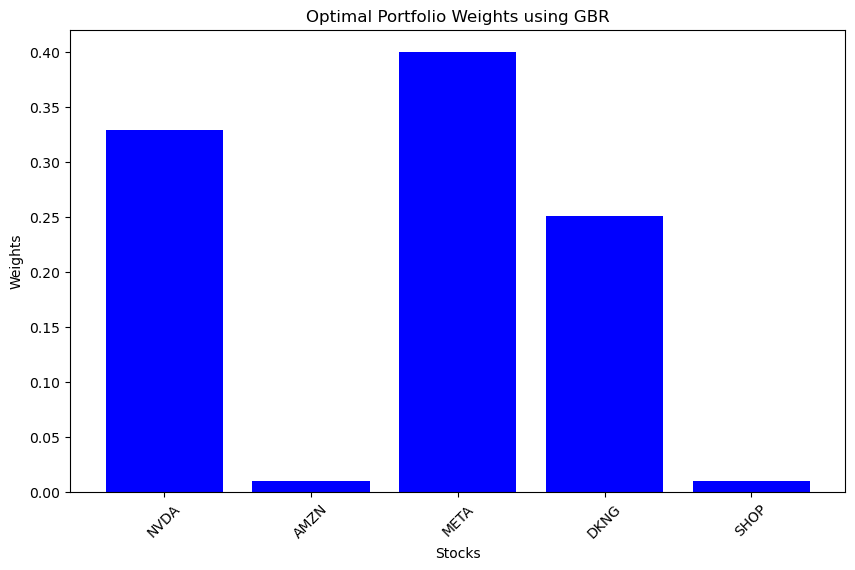

In [13]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import random
from deap import base, creator, tools, algorithms
from sklearn.tree import DecisionTreeRegressor

from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error

stocks = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'META', 'TSLA', 'BABA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'KO', 'PEP', 
          'MCD', 'SBUX', 'NKE', 'DIS', 'NFLX', 'CMCSA', 'VZ', 'T', 'COST', 'CVS', 'UNH', 'PFE', 'MRK', 'ABBV', 
          'BMY', 'XOM', 'CVX', 'COP', 'SLB', 'HAL', 'GE', 'BA', 'LMT', 'RTX', 'NOC', 'CAT', 'DE', 'MMM', 'HON', 
          'IBM', 'INTC', 'AMD', 'NVDA', 'QCOM', 'ORCL', 'CSCO', 'CRM', 'ADBE', 'ACN', 'MA', 'PYPL', 'SQ', 'SHOP', 
          'BAC', 'C', 'WFC', 'GS', 'BLK', 'BRK-B', 'AXP', 'TMUS', 'SPY', 'QQQ', 'DIA', 'IWM', 'GLD', 'SLV', 'USO',
            'TLT', 'HYG', 'LQD', 'EEM', 'EFA', 'FXI', 'EWJ', 'EWZ', 'RSX', 'VWO', 'VGK', 'VNQ', 'SCHH', 'XLE', 'XLF',
              'XLK', 'XLY', 'XLP', 'XLU', 'XLV', 'XLB', 'XLI','ZM','SNOW','NIO','SPCE','PLTR','DKNG']

start_date = '2023-01-01'
end_date = '2024-01-01'

# Veri çekme ve ön işleme
data = yf.download(stocks, start=start_date, end=end_date)['Adj Close'].dropna(axis=1)
returns = data.pct_change().dropna()

# Tahminler için bir sözlük oluştur
predicted_returns_gbr = {}

# Her hisse senedi için bir GBR modeli eğit
for stock in stocks:
    y = returns[stock]
    X = returns.drop(columns=stock)
    
    common_index = X.index.intersection(y.index)
    X = X.loc[common_index]
    y = y.loc[common_index]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    gbr = GradientBoostingRegressor(n_estimators=100, random_state=42)
    gbr.fit(X_train_scaled, y_train)
    
    predicted_returns_gbr[stock] = np.mean(gbr.predict(X_test_scaled))

# Tahmin edilen getirilere göre en iyi 5 hisse senedini seç
top_5_stocks_gbr = sorted(predicted_returns_gbr, key=predicted_returns_gbr.get, reverse=True)[:5]
print("Top 5 Predicted Performing Stocks using GBR:", top_5_stocks_gbr)

selected_returns_gbr = returns[top_5_stocks_gbr]
selected_cov_matrix_gbr = selected_returns_gbr.cov()

def negative_sharpe_ratio_gbr(weights, returns, cov_matrix, risk_free_rate=0.01):
    p_returns = np.dot(weights, returns.mean()) * 252
    p_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))
    sharpe_ratio = (p_returns - risk_free_rate) / p_volatility
    return -sharpe_ratio

initial_weights_gbr = np.ones(len(top_5_stocks_gbr)) / len(top_5_stocks_gbr)
constraints_gbr = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Minimum ağırlık değeri belirleyin
min_weight = 0.01  # Örneğin, her hisse için minimum %1 ağırlık

# Sınırları ayarlayın
bounds_gbr = [(min_weight, 1) for _ in range(len(top_5_stocks_gbr))]

# Portföy optimizasyonunu tekrar çalıştırın
result_gbr = minimize(negative_sharpe_ratio_gbr, initial_weights_gbr, args=(selected_returns_gbr, selected_cov_matrix_gbr),
                      method='SLSQP', bounds=bounds_gbr, constraints=constraints_gbr)

if result_gbr.success:
    optimal_weights_gbr = result_gbr.x
    print("Optimal Weights using GBR:", optimal_weights_gbr)
    
    plt.figure(figsize=(10, 6))
    plt.bar(top_5_stocks_gbr, optimal_weights_gbr, color='blue')
    plt.xlabel('Stocks')
    plt.ylabel('Weights')
    plt.title('Optimal Portfolio Weights using GBR')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("Optimization failed:", result_gbr.message)



Beklenen portföy getirisini, volatiliteyi ve Sharpe oranını hesaplayan fonksiyonlar yazılır.
GBR ile hisse senedi getirileri tahmin edilir ve gerçek getirilerle karşılaştırılır.
Veriyi eğitim ve test setlerine ayırma yapılır.
Eksik değerlerin doldurulması ve ölçeklendirme yapılır bu bize daha iyi değer sunar.
Model oluşturulur ve eğitilir.
y_test içinde NaN değerlerin kontrolü ve temizleme yapar.
Son olarak model performansı değerlendirilir ve görselleştirme yapılır.

[*********************100%%**********************]  100 of 100 completed


Top 5 Predicted Performing Stocks using Random Forest: ['NVDA', 'DKNG', 'SHOP', 'AMZN', 'META']
Optimal Weights using Random Forest: [0.30804799 0.22866118 0.05       0.05       0.36329083]


/Users/fatihbayazit/anaconda3/lib/python3.11/site-packages/scipy/optimize/_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


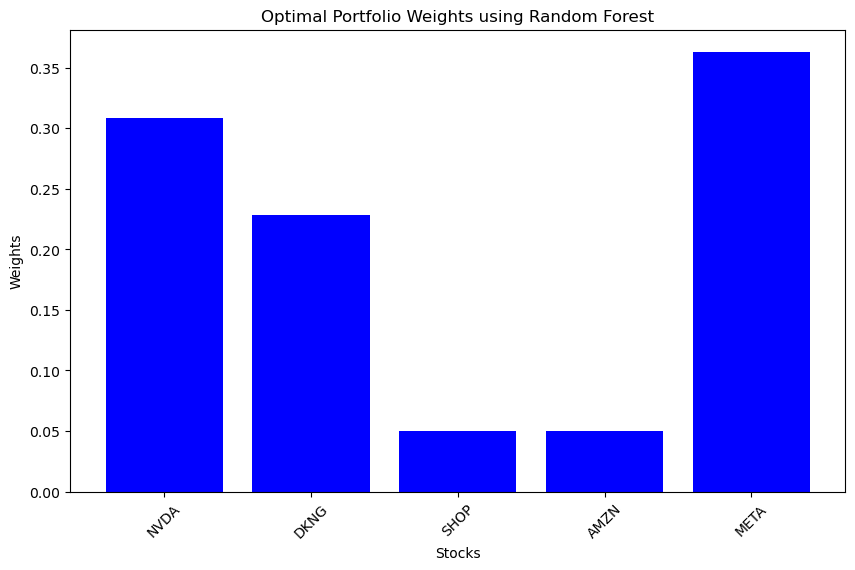

In [14]:
#Random forest ile hisse senedi getirileri tahmin edilir ve en iyi 5 hisse senedi seçilir.
from sklearn.impute import SimpleImputer
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import random
from deap import base, creator, tools, algorithms
from sklearn.tree import DecisionTreeRegressor

from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error

stocks = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'META', 'TSLA', 'BABA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'KO', 'PEP', 
          'MCD', 'SBUX', 'NKE', 'DIS', 'NFLX', 'CMCSA', 'VZ', 'T', 'COST', 'CVS', 'UNH', 'PFE', 'MRK', 'ABBV', 
          'BMY', 'XOM', 'CVX', 'COP', 'SLB', 'HAL', 'GE', 'BA', 'LMT', 'RTX', 'NOC', 'CAT', 'DE', 'MMM', 'HON', 
          'IBM', 'INTC', 'AMD', 'NVDA', 'QCOM', 'ORCL', 'CSCO', 'CRM', 'ADBE', 'ACN', 'MA', 'PYPL', 'SQ', 'SHOP', 
          'BAC', 'C', 'WFC', 'GS', 'BLK', 'BRK-B', 'AXP', 'TMUS', 'SPY', 'QQQ', 'DIA', 'IWM', 'GLD', 'SLV', 'USO',
            'TLT', 'HYG', 'LQD', 'EEM', 'EFA', 'FXI', 'EWJ', 'EWZ', 'RSX', 'VWO', 'VGK', 'VNQ', 'SCHH', 'XLE', 'XLF',
              'XLK', 'XLY', 'XLP', 'XLU', 'XLV', 'XLB', 'XLI','ZM','SNOW','NIO','SPCE','PLTR','DKNG']

start_date = '2023-01-01'
end_date = '2024-01-01'

# Veri çekme ve ön işleme
data = yf.download(stocks, start=start_date, end=end_date)['Adj Close'].dropna(axis=1)
returns = data.pct_change().dropna()

from sklearn.ensemble import RandomForestRegressor

# Tahminler için bir sözlük oluştur
predicted_returns_rf = {}

# Model parametrelerini değiştir
n_estimators = 200
max_depth = 10

# Her hisse senedi için bir Random Forest modeli eğit
for stock in stocks:
    y = returns[stock]
    X = returns.drop(columns=stock)
    
    common_index = X.index.intersection(y.index)
    X = X.loc[common_index]
    y = y.loc[common_index]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    rf.fit(X_train, y_train)  # RandomForest için ölçeklendirme gerekli değil
    
    predicted_returns_rf[stock] = np.mean(rf.predict(X_test))

# Tahmin edilen getirilere göre en iyi 5 hisse senedini seç
top_5_stocks_rf = sorted(predicted_returns_rf, key=predicted_returns_rf.get, reverse=True)[:5]
print("Top 5 Predicted Performing Stocks using Random Forest:", top_5_stocks_rf)

selected_returns_rf = returns[top_5_stocks_rf]
selected_cov_matrix_rf = selected_returns_rf.cov()

def negative_sharpe_ratio_rf(weights, returns, cov_matrix, risk_free_rate=0.01):
    p_returns = np.dot(weights, returns.mean()) * 252
    p_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))
    sharpe_ratio = (p_returns - risk_free_rate) / p_volatility
    return -sharpe_ratio

# Ağırlık kısıtlamaları ekleyerek başlangıç ağırlıkları ve kısıtlamaları ayarlayın
min_weight_per_stock = 0.05  # Her hisse senedi için minimum %5 ağırlık
initial_weights_rf = np.ones(len(top_5_stocks_rf)) / len(top_5_stocks_rf)
bounds_rf = [(min_weight_per_stock, 1.0)] * len(top_5_stocks_rf)
constraints_rf = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Portföy optimizasyonu, SLSQP metodu kullanılarak
result_rf = minimize(negative_sharpe_ratio_rf, initial_weights_rf, args=(selected_returns_rf, selected_cov_matrix_rf),
                  method='SLSQP', bounds=bounds_rf, constraints=constraints_rf)

if result_rf.success:
    optimal_weights_rf = result_rf.x
    print("Optimal Weights using Random Forest:", optimal_weights_rf)
    
    plt.figure(figsize=(10, 6))
    plt.bar(top_5_stocks_rf, optimal_weights_rf, color='blue')
    plt.xlabel('Stocks')
    plt.ylabel('Weights')
    plt.title('Optimal Portfolio Weights using Random Forest')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("Optimization failed:", result_rf.message)



Özellikler ve hedeflerin belirlenir.
Ortak indeksi olan veriyi eşleştirilir.
Veriyi eğitim ve test setlerine ayırma yapılır.
Rastgele Orman modelini oluşturulur ve eğitilir.
Tahminler yapılır
Modelin performansını değerlendirilir.
Gerçek değerlerle tahminleri karşılaştırılır.
Görselleştirme yapılır.